In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import json
import os
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
dir_path = '/content/gdrive/My Drive/Oil_Tanks/'

f = open(dir_path + 'labels.json')
labels = json.load(f)

In [ ]:
f = open(r'/content/gdrive/My Drive/Oil_Tanks/Darknet/data/labels_coco.json')
labels_coco = json.load(f)

bbox : Bounding box in COCO is the x and y co-ordinate of the top left and the height and width. Pascal VOC bounding box is the x and y co-ordinates of the top left and x and y co-ordinates of the bottom right edge of the rectangle.

https://towardsdatascience.com/coco-data-format-for-object-detection-a4c5eaf518c5

COCO Bounding box: (x-top left, y-top left, width, height)

Pascal VOC Bounding box :(x-top left, y-top left,x-bottom right, y-bottom right)


# Checking for Data Leakage

In [ ]:
with open(r'/content/gdrive/My Drive/Oil_Tanks/Darknet/data/train.txt', 'r') as f:
  train = f.readlines()
with open(r'/content/gdrive/My Drive/Oil_Tanks/Darknet/data/test.txt', 'r') as f:
  test = f.readlines()
with open(r'/content/gdrive/My Drive/Oil_Tanks/Darknet/data/valid.txt', 'r') as f:
  valid = f.readlines()

print(len(train))
print(len(test))
print(len(valid))

test1 = [i.split('.')[0] for i in test]
valid1 = [i.split('.')[0] for i in valid]
train1 = [i.split('.')[0] for i in train]

12410
980
1000


In [ ]:
from tqdm import tqdm
duplicates = set()

for i in tqdm(range(len(valid1))):

  for train_file in train:
    if valid1[i] in train_file: 
      duplicates.add(valid1[i])
      #print(i)

len(duplicates)

100%|██████████| 1000/1000 [00:01<00:00, 683.13it/s]


177

In [ ]:
items = [[s for i, s in enumerate(train) if j in s] for j in duplicates]
print(len(items))
print(items[0])
print(items[2])

177
['data/myfile/15_8_0_90.jpg\n', 'data/myfile/15_8_0_180.jpg\n', 'data/myfile/15_8_0_270.jpg\n']
['data/myfile/91_4_2_90.jpg\n', 'data/myfile/91_4_2_180.jpg\n', 'data/myfile/91_4_2_270.jpg\n']


In [ ]:
import random
random.shuffle(train)

In [ ]:
with open(r'/content/gdrive/My Drive/Oil Tanks/Darknet/data/train.txt', 'w') as f:
  f.writelines(train)

# Data Augmentation

Rotating Image

In [ ]:
def rotate_im(image, angle):

    (h, w) = image.shape[:2] # grab the dimensions of the image and then determine the
    (cX, cY) = (w // 2, h // 2) # centre

    # grab the rotation matrix (applying the negative of the angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

    return image

Getting Bouding box for rotated images

In [ ]:
def get_corners(label_row):
    
    width = float(label_row.split(" ")[3])*512
    height = float(label_row.split(" ")[4])*512
    x_center = float(label_row.split(" ")[1])*512
    y_center = float(label_row.split(" ")[2])*512
    
    x1, y1 = int(x_center - width/2), int(y_center - height/2)
    x2, y2 = int(x_center + width/2), int(y_center - height/2)
    x3, y3 = int(x_center + width/2), int(y_center + height/2)
    x4, y4 = int(x_center - width/2), int(y_center + height/2)
  
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners

In [ ]:
def rotate_box(corners, angle,  cx, cy, h, w):
    
    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0])))) #making all coordinates 3dim
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated

In [ ]:
def get_enclosing_box(corners):

    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)
    
    width = int(xmax - xmin)
    heigth = int(ymax - ymin)
    x_cen = int((xmin + xmax)/2)
    y_cen = int((ymin + ymax)/2)

    final = [x_cen/512, y_cen/512, width/512, heigth/512]
    
    return final

# Calling all functions and Augmenting Data

In [ ]:
def augment_data(all_labels):
  new_files = []
  for label in all_labels:
    
    #do augmentation only if label isn't skip
    if label['label'] != 'Skip':

      fileaspath = r'/content/gdrive/My Drive/Oil Tanks/Darknet/data/myfile/' + label['file_name']
      image = cv2.imread(fileaspath, cv2.IMREAD_COLOR)
      with open(r'/content/gdrive/My Drive/Oil Tanks/Darknet/data/labels/'+ label['file_name'].split(".")[0] + ".txt", 'r') as f:
        label_file = f.readlines()
      
      for angle in [90,180,270]:
        texttowrite = []
        for row in label_file:

          row = re.sub("\n", "", row)
          class_ = str(row.split(" ")[0]) 
          corners = get_corners(row)
          rotated = rotate_box(corners, angle, 512/2, 512/2, 512, 512)
          augmented_data = get_enclosing_box(rotated)
          texttowrite.append(class_ + " " + " ".join([str(i) for i in augmented_data]))
        
        #new label file
        with open(r'/content/gdrive/My Drive/Oil Tanks/Darknet/data/labels_01/'+ label['file_name'].split(".")[0] + "_"+ str(angle) + ".txt", 'w') as f:
          f.writelines("\n".join(texttowrite))

        #new image file
        imfg = rotate_im(image, angle)
        cv2.imwrite(r'/content/gdrive/My Drive/Oil Tanks/Darknet/data/myfile_01/' + label['file_name'].split(".")[0] + "_" + str(angle) + ".jpg" , imfg)

        new_files.append(label['file_name'].split(".")[0] + "_"+ str(angle) + ".txt")
      
  return new_files


new_files = augment_data(labels)

# Checking number of Augmented files

In [ ]:
import os
print(len(new_files))

a = os.listdir(r"/content/gdrive/My Drive/Oil Tanks/Darknet/data/myfile_01")
print(len(a))

b = os.listdir(r"/content/gdrive/My Drive/Oil Tanks/Darknet/data/labels_01")
print(len(b))

5487
5487
5487


# Yolo v3

# Training Model

In [ ]:
%cd /content/gdrive/My Drive/Oil Tanks/Darknet

/content/gdrive/My Drive/Oil Tanks/Darknet


In [ ]:
#Cloning DarkNet github repo
#!git clone 'https://github.com/AlexeyAB/darknet.git' '/content/gdrive/My Drive/Oil Tanks/Darknet'

Cloning into '/content/gdrive/My Drive/Oil Tanks/Darknet'...
remote: Enumerating objects: 15502, done.
remote: Total 15502 (delta 0), reused 0 (delta 0), pack-reused 15502
Receiving objects: 100% (15502/15502), 14.17 MiB | 5.59 MiB/s, done.
Resolving deltas: 100% (10403/10403), done.
Checking out files: 100% (2057/2057), done.


In [ ]:
!ls

3rdparty	CMakeLists.txt		image_yolov4.sh        README.md
backup		darknet			include		       results
bad_label.list	DarknetConfig.cmake.in	json_mjpeg_streams.sh  scripts
bad.list	darknet_images.py	LICENSE		       src
build		darknet.py		Makefile	       vcpkg.json
build.ps1	darknet_video.py	net_cam_v3.sh	       video_yolov3.sh
cfg		data			net_cam_v4.sh	       video_yolov4.sh
cmake		image_yolov3.sh		obj


In [ ]:
!make

chmod +x *.sh


In [ ]:
!chmod +x ./darknet

In [ ]:
! ./darknet detector train data/myfile.data custom_cfg/yolov3_custom.cfg data/darknet53.conv.74 -map -dont_show

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000002, iou_loss = 0.000000, total_loss = 0.000002 
 total_bbox = 665447, rewritten_bbox = 0.007664 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.890749), count: 6, class_loss = 0.005387, iou_loss = 0.078733, total_loss = 0.084120 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.904865), count: 1, class_loss = 0.082661, iou_loss = 0.020519, total_loss = 0.103179 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000050, iou_loss = 0.000000, total_loss = 0.000050 
 total_bbox = 665454, rewritten_bbox = 0.007664 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.909056), count: 3, class_loss = 0.000003, iou_loss = 0.035533, total_loss = 0.035536 
v3 (m

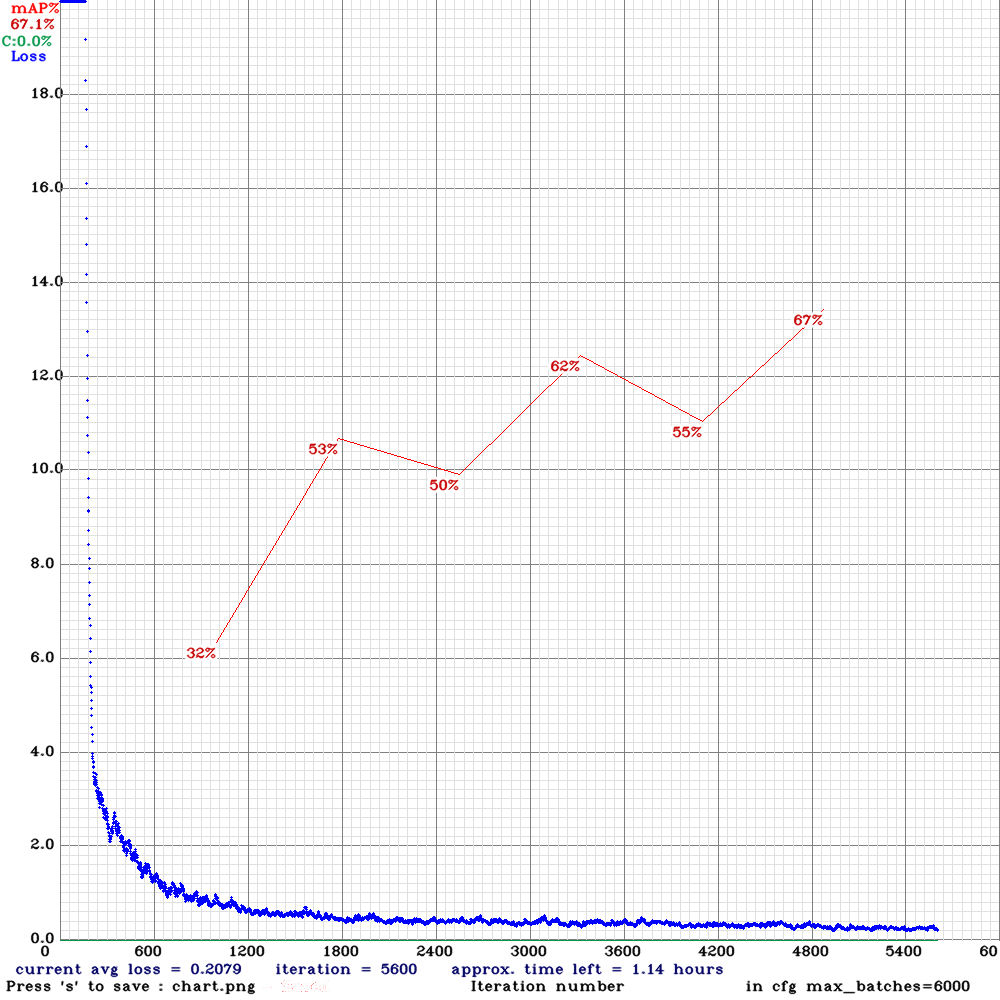

# MAP on Validation file

In [ ]:
! ./darknet detector map data/myfile.data cfg/yolov3_custom.cfg backup/yolov3_custom_best.weights

 CUDA-version: 11020 (11020), cuDNN: 8.1.1, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    512 x 512 x   3 ->  512 x 512 x  32 0.453 BF
   1 conv     64       3 x 3/ 2    512 x 512 x  32 ->  256 x 256 x  64 2.416 BF
   2 conv     32       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  32 0.268 BF
   3 conv     64       3 x 3/ 1    256 x 256 x  32 ->  256 x 256 x  64 2.416 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 256 x 256 x  64 0.004 BF
   5 conv    128       3 x 3/ 2    256 x 256 x  64 ->  128 x 128 x 128 2.416 BF
   6 conv     64       1 x 1/ 1    128 x 128 x 128 ->  128 x 128 x  64 0.268 BF
   7 conv    128       3 x 3/ 1    128 x 128 x  64 ->  128 x 128 x 128 2.416 BF
   8 Shortcut Layer: 5, 

# MAP on test file

In [ ]:
! ./darknet detector map data/myfile.data cfg/yolov3_custom.cfg backup/yolov3_custom_last.weights -dont_show #-ext_output <data/test.txt> data/result1.txt
#! ./darknet detector map data/myfile.data cfg/yolov3_custom.cfg backup/yolov3_custom_last.weights

 CUDA-version: 11020 (11020), cuDNN: 8.1.1, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    512 x 512 x   3 ->  512 x 512 x  32 0.453 BF
   1 conv     64       3 x 3/ 2    512 x 512 x  32 ->  256 x 256 x  64 2.416 BF
   2 conv     32       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  32 0.268 BF
   3 conv     64       3 x 3/ 1    256 x 256 x  32 ->  256 x 256 x  64 2.416 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 256 x 256 x  64 0.004 BF
   5 conv    128       3 x 3/ 2    256 x 256 x  64 ->  128 x 128 x 128 2.416 BF
   6 conv     64       1 x 1/ 1    128 x 128 x 128 ->  128 x 128 x  64 0.268 BF
   7 conv    128       3 x 3/ 1    128 x 128 x  64 ->  128 x 128 x 128 2.416 BF
   8 Shortcut Layer: 5, 

# Observations - Yolo v3

In the problem statement, we are tasked with detecting Floating Head Tanks in the images. WE will look at the model performance

MAP score on Validation set which is used while training

class_id = 0, name = Floating Head Tank, ap = 98.74%

MAP score on Test set

class_id = 0, name = Floating Head Tank, ap = 97.46%   

# Yolo v4

Training

In [ ]:
! ./darknet detector train custom_cfg/custom.data custom_cfg/yolov3_custom.cfg data/yolov4.conv.137 -map -dont_show

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.894941), count: 9, class_loss = 0.009538, iou_loss = 0.077635, total_loss = 0.087173 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000019, iou_loss = 0.000000, total_loss = 0.000019 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000347, iou_loss = 0.000000, total_loss = 0.000347 
 total_bbox = 703799, rewritten_bbox = 0.005115 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.895415), count: 1, class_loss = 0.000003, iou_loss = 0.009408, total_loss = 0.009410 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.850755), count: 5, class_loss = 0.524720, iou_loss = 0.117839, total_loss = 0.642559 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.0

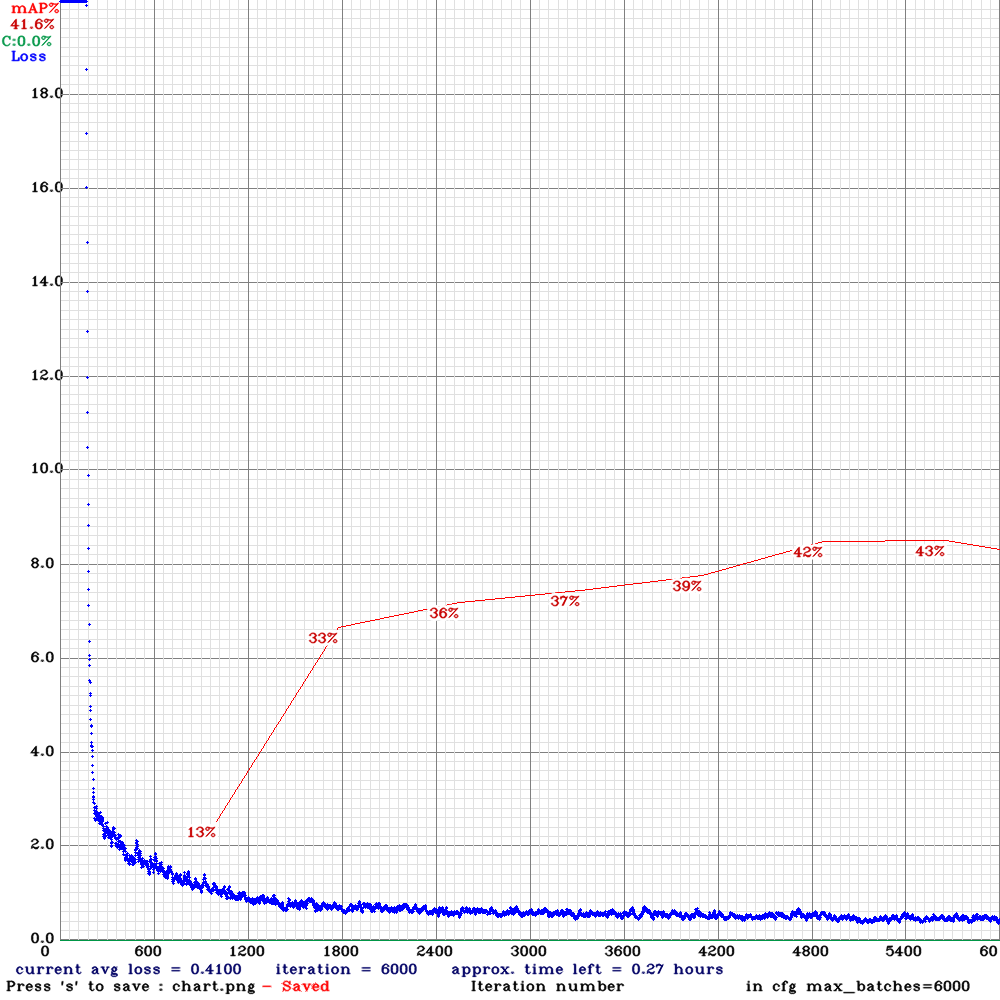

MAP on validation data

In [ ]:
! ./darknet detector map data/myfile.data cfg/yolov3_custom.cfg backup/yolov3_custom_best.weights

 CUDA-version: 11020 (11020), cuDNN: 8.1.1, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    512 x 512 x   3 ->  512 x 512 x  32 0.453 BF
   1 conv     64       3 x 3/ 2    512 x 512 x  32 ->  256 x 256 x  64 2.416 BF
   2 conv     32       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  32 0.268 BF
   3 conv     64       3 x 3/ 1    256 x 256 x  32 ->  256 x 256 x  64 2.416 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 256 x 256 x  64 0.004 BF
   5 conv    128       3 x 3/ 2    256 x 256 x  64 ->  128 x 128 x 128 2.416 BF
   6 conv     64       1 x 1/ 1    128 x 128 x 128 ->  128 x 128 x  64 0.268 BF
   7 conv    128       3 x 3/ 1    128 x 128 x  64 ->  128 x 128 x 128 2.416 BF
   8 Shortcut Layer: 5, 

Test data

In [ ]:
! ./darknet detector map data/myfile.data cfg/yolov3_custom.cfg backup/yolov3_custom_best.weights -dont_show

 CUDA-version: 11020 (11020), cuDNN: 8.1.1, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    512 x 512 x   3 ->  512 x 512 x  32 0.453 BF
   1 conv     64       3 x 3/ 2    512 x 512 x  32 ->  256 x 256 x  64 2.416 BF
   2 conv     32       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  32 0.268 BF
   3 conv     64       3 x 3/ 1    256 x 256 x  32 ->  256 x 256 x  64 2.416 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 256 x 256 x  64 0.004 BF
   5 conv    128       3 x 3/ 2    256 x 256 x  64 ->  128 x 128 x 128 2.416 BF
   6 conv     64       1 x 1/ 1    128 x 128 x 128 ->  128 x 128 x  64 0.268 BF
   7 conv    128       3 x 3/ 1    128 x 128 x  64 ->  128 x 128 x 128 2.416 BF
   8 Shortcut Layer: 5, 

MAP score on Validation set which is used while training

class_id = 0, name = Floating Head Tank, ap = 94.56%

MAP score on Test set

class_id = 0, name = Floating Head Tank, ap = 91.83%

# Yolo v5

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import cv2
from google.colab.patches import cv2_imshow
import re
import shutil

In [ ]:
! pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.8 MB/s eta 0:00:00


In [ ]:
%cd '/content/gdrive/My Drive/Oil_Tanks'

/content/gdrive/My Drive/Oil_Tanks


In [ ]:
#!git clone 'https://github.com/ultralytics/yolov5'

#YOLOv5 is out of date by 4 commits. 
#Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.

/content/gdrive/My Drive/Oil Tanks
Cloning into 'yolov5'...
remote: Enumerating objects: 14978, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 14978 (delta 18), reused 21 (delta 8), pack-reused 14936
Receiving objects: 100% (14978/14978), 13.97 MiB | 6.13 MiB/s, done.
Resolving deltas: 100% (10282/10282), done.
Checking out files: 100% (145/145), done.


Train

In [ ]:
%cd /content/gdrive/My Drive/Oil_Tanks/yolov5

/content/gdrive/My Drive/Oil_Tanks/yolov5


In [ ]:
!python train.py --img 512 --batch 32 --epochs 500 --data yolov5_custom.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=yolov5_custom.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=500, batch_size=32, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 4 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v7.0-66-g9650f16 Python-3.8.16 torch-1.13.0+cu116 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_g

Validation

In [ ]:
!python val.py --weights runs/train/exp10/weights/best.pt --data yolov5_custom.yaml --img 512 --half

val: data=/content/gdrive/MyDrive/Oil_Tanks/yolov5/data/yolov5_custom.yaml, weights=['runs/train/exp10/weights/best.pt'], batch_size=32, imgsz=512, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-66-g9650f16 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
100% 755k/755k [00:00<00:00, 141MB/s]
val: Scanning /content/gdrive/MyDrive/Oil_Tanks/yolov5/data/labels/validation.cache... 1000 images, 823 backgrounds, 0 corrupt: 100% 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 32/32 [00:27<00:00,  1.15it/s]
                   all       1000        897       0.81      0.507      0.491      0.362
   

Test Dataset

In [ ]:
!python val.py --weights runs/train/exp10/weights/best.pt --data yolov5_custom.yaml --img 512 --half

val: data=/content/gdrive/MyDrive/Oil_Tanks/yolov5/data/yolov5_custom.yaml, weights=['runs/train/exp10/weights/best.pt'], batch_size=32, imgsz=512, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-66-g9650f16 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/gdrive/MyDrive/Oil_Tanks/yolov5/data/labels/test... 980 images, 798 backgrounds, 0 corrupt: 100% 980/980 [02:46<00:00,  5.88it/s]
val: New cache created: /content/gdrive/MyDrive/Oil_Tanks/yolov5/data/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 31/31 [00:12<00:00,  2.57it/s]
                   all        980        903     

# After Data Augmentation

In [ ]:
#reading text and validation files
with open(r'/content/gdrive/My Drive/Oil_Tanks/Darknet/data/train8k.txt', 'r') as f:
  train = f.readlines()
with open(r'/content/gdrive/My Drive/Oil_Tanks/Darknet/data/valid.txt', 'r') as f:
  valid = f.readlines()
with open(r'/content/gdrive/My Drive/Oil_Tanks/Darknet/data/test.txt', 'r') as f:
  test = f.readlines()
  

print(len(train))
print(len(valid))
print(len(test))

8000
1000
980


In [ ]:
train = [re.sub("\n", "", i.split("/")[-1].split(".")[0]+'.txt') for i in train]
valid = [re.sub("\n", "", i.split("/")[-1].split(".")[0]+'.txt') for i in valid]
test = [re.sub("\n", "", i.split("/")[-1].split(".")[0]+'.txt') for i in test]

valid = [i.split(".")[0] for i in valid]
test = [i.split(".")[0] for i in test]

In [ ]:
valid[-5:]

['23_7_5', '01_8_7', '38_6_2', '60_8_0', '27_7_5']

In [ ]:
%cd '/content/gdrive/My Drive/Oil_Tanks/yolov5/data/images/augmented'
aug_images = os.listdir()

In [ ]:
c=0
for i in aug_images:
  original_i = i.split('_')[0]+'_'+ i.split('_')[1]+'_'+i.split('_')[2]

  if (original_i not in valid) and (original_i not in test): 
    c+=1
    shutil.copy(i , "/content/gdrive/My Drive/Oil_Tanks/yolov5/data/images/train")
c 

4410

Training

In [ ]:
%cd /content/gdrive/My Drive/Oil_Tanks/yolov5

/content/gdrive/My Drive/Oil_Tanks/yolov5


In [ ]:
!python train.py --img 512 --batch 32 --epochs 10 --data yolov5_custom_val.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=yolov5_custom_val.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=32, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch origin' timed out after 5 seconds
fatal: cannot change to '/content/gdrive/My': No such file or directory
YOLOv5 🚀 2023-1-14 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2,

training further epochs

In [ ]:
!python train.py --img 512 --batch 32 --epochs 10 --data yolov5_custom_val.yaml --weights runs/train/exp/weights/best.pt

train: weights=runs/train/exp/weights/best.pt, cfg=, data=yolov5_custom_val.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=32, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 5 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v7.0-66-g9650f16 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj

Validation dataset

In [ ]:
!python val.py --weights runs/train/exp2/weights/best.pt --data yolov5_custom_val.yaml --img 512 --half

val: data=/content/gdrive/MyDrive/Oil_Tanks/yolov5/data/yolov5_custom_val.yaml, weights=['runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=512, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-66-g9650f16 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/gdrive/MyDrive/Oil_Tanks/yolov5/data/labels/validation.cache... 1000 images, 823 backgrounds, 0 corrupt: 100% 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 32/32 [00:08<00:00,  3.68it/s]
                   all       1000        897      0.692      0.629      0.656        0.5
    Floating Head Tank       1000     

Test dataset

In [ ]:
!python val.py --weights runs/train/exp2/weights/best.pt --data yolov5_custom_test.yaml --img 512 --half

val: data=/content/gdrive/MyDrive/Oil_Tanks/yolov5/data/yolov5_custom_test.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=512, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-66-g9650f16 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/gdrive/MyDrive/Oil_Tanks/yolov5/data/labels/test.cache... 980 images, 798 backgrounds, 0 corrupt: 100% 980/980 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 31/31 [00:21<00:00,  1.47it/s]
                   all        980        903      0.424      0.602      0.508      0.424
    Floating Head Tank        980        687   

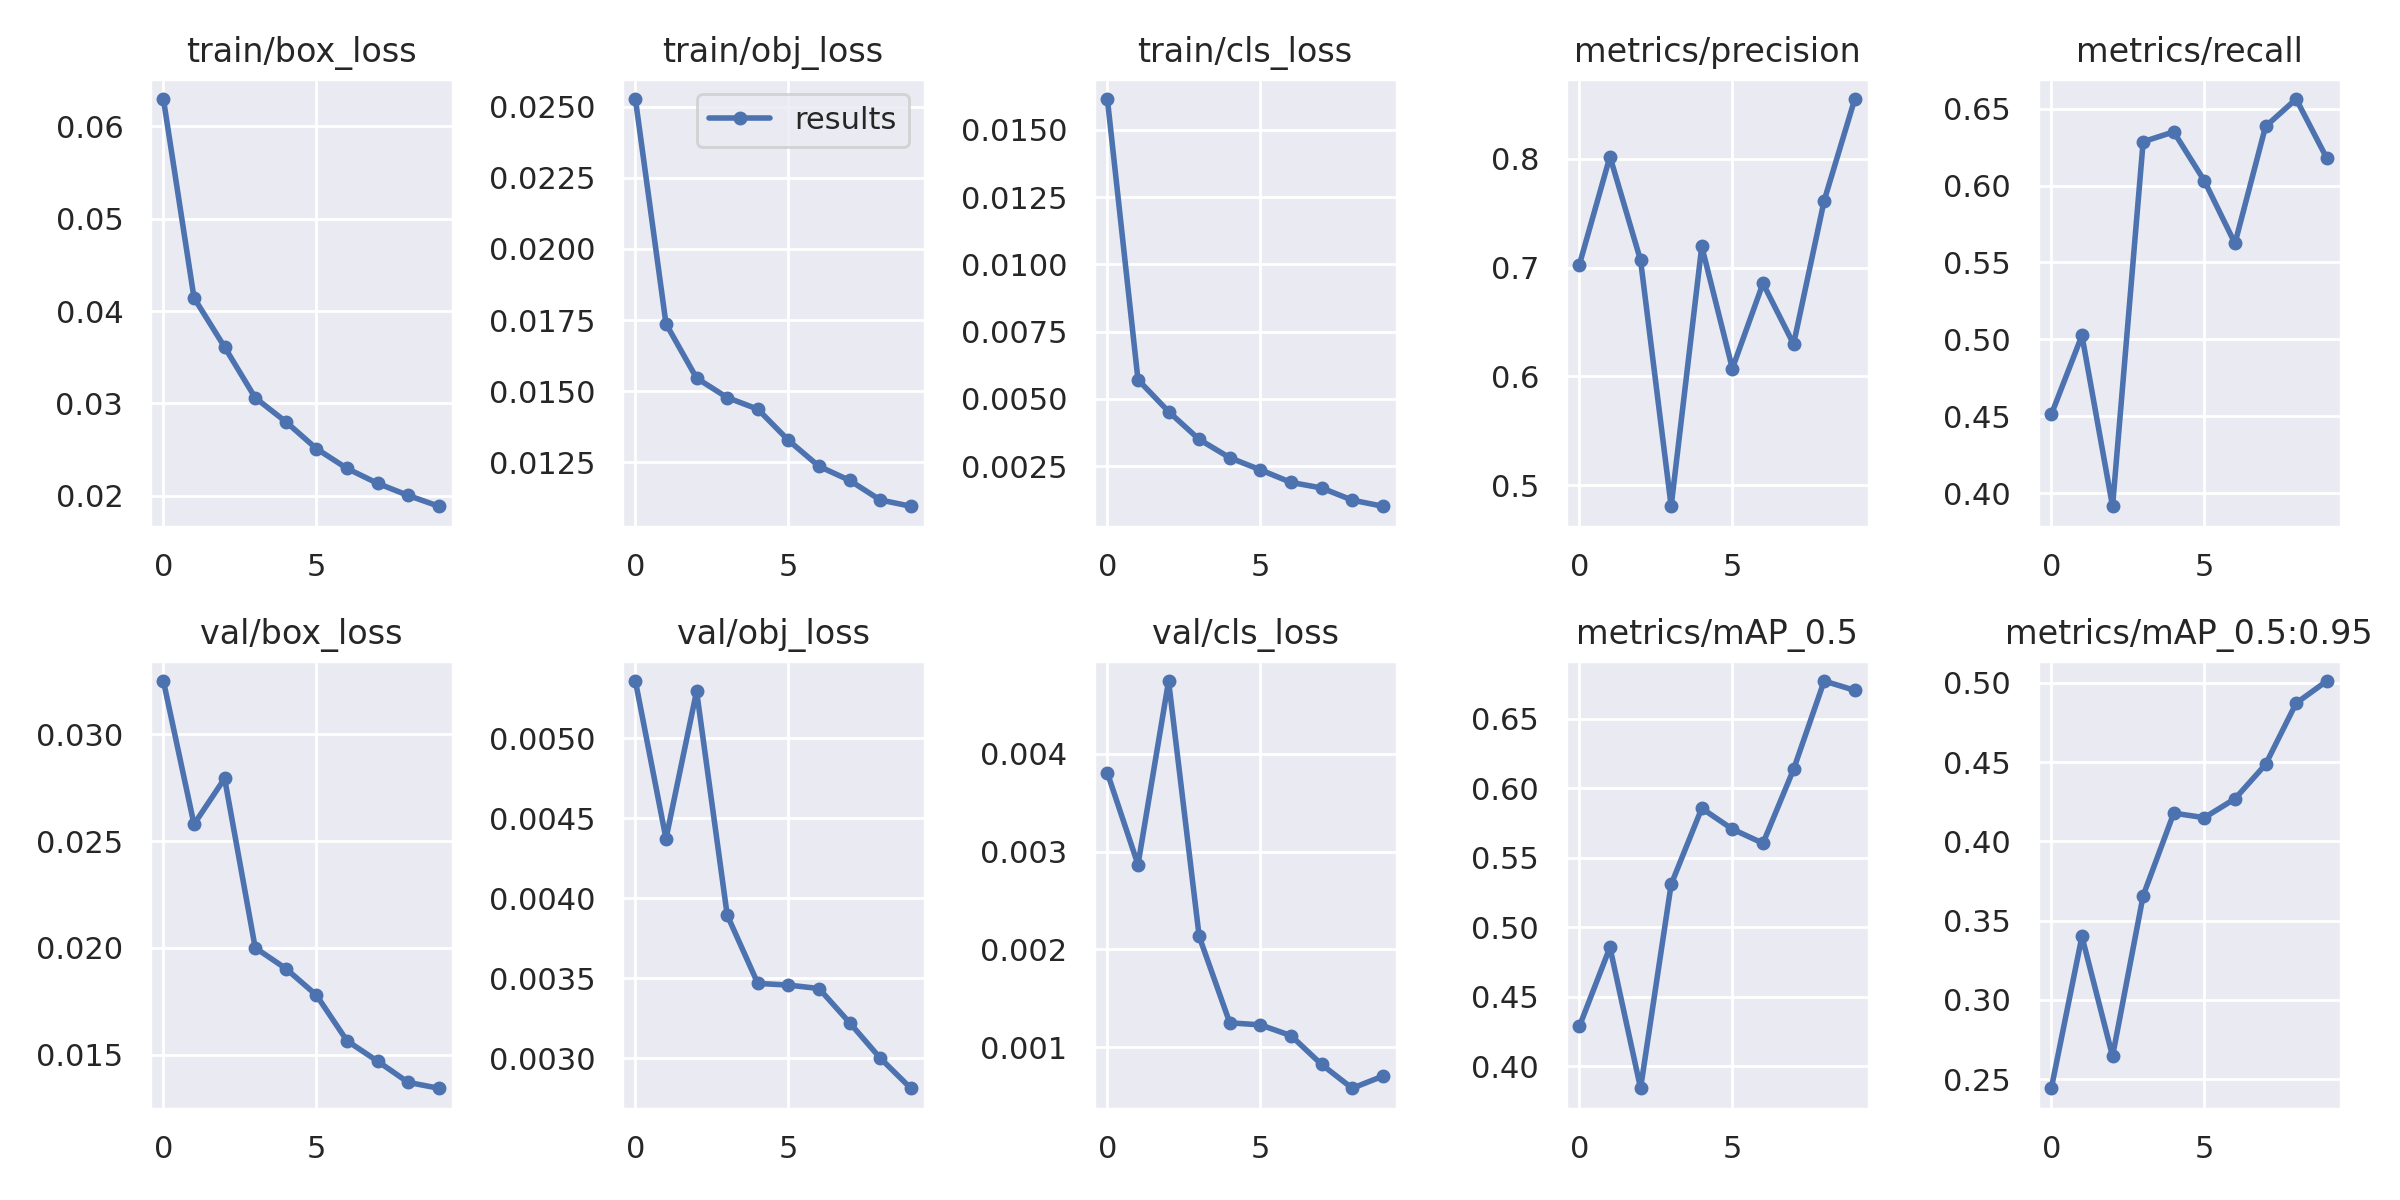

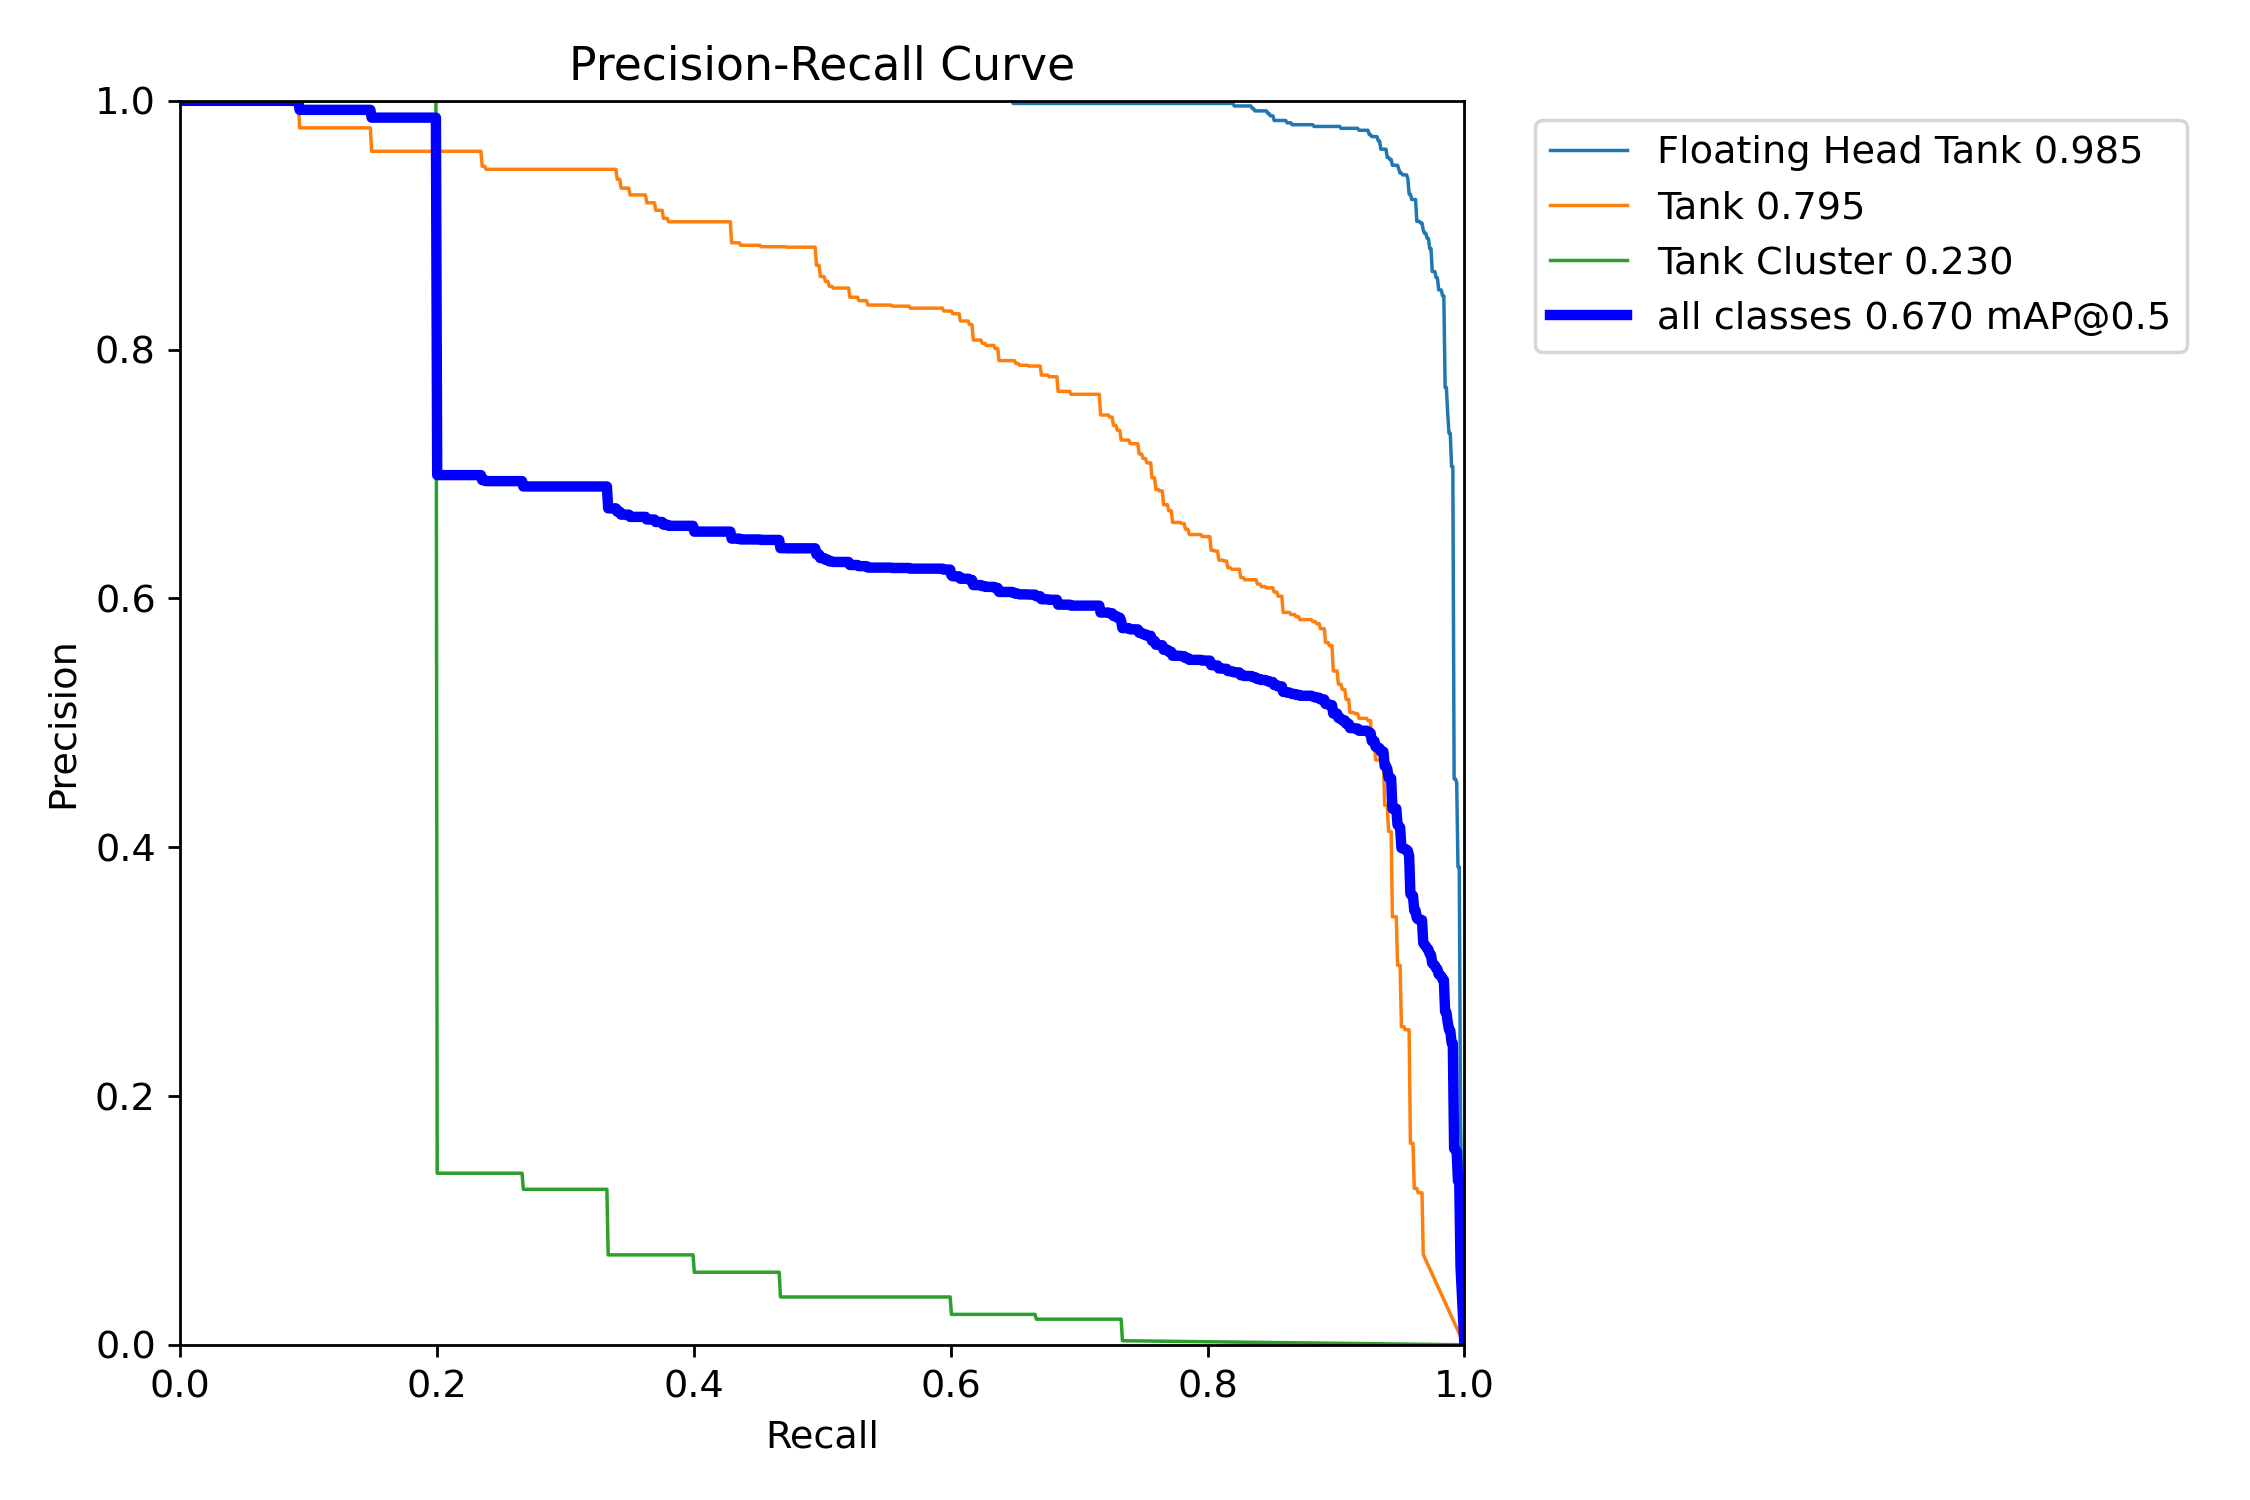

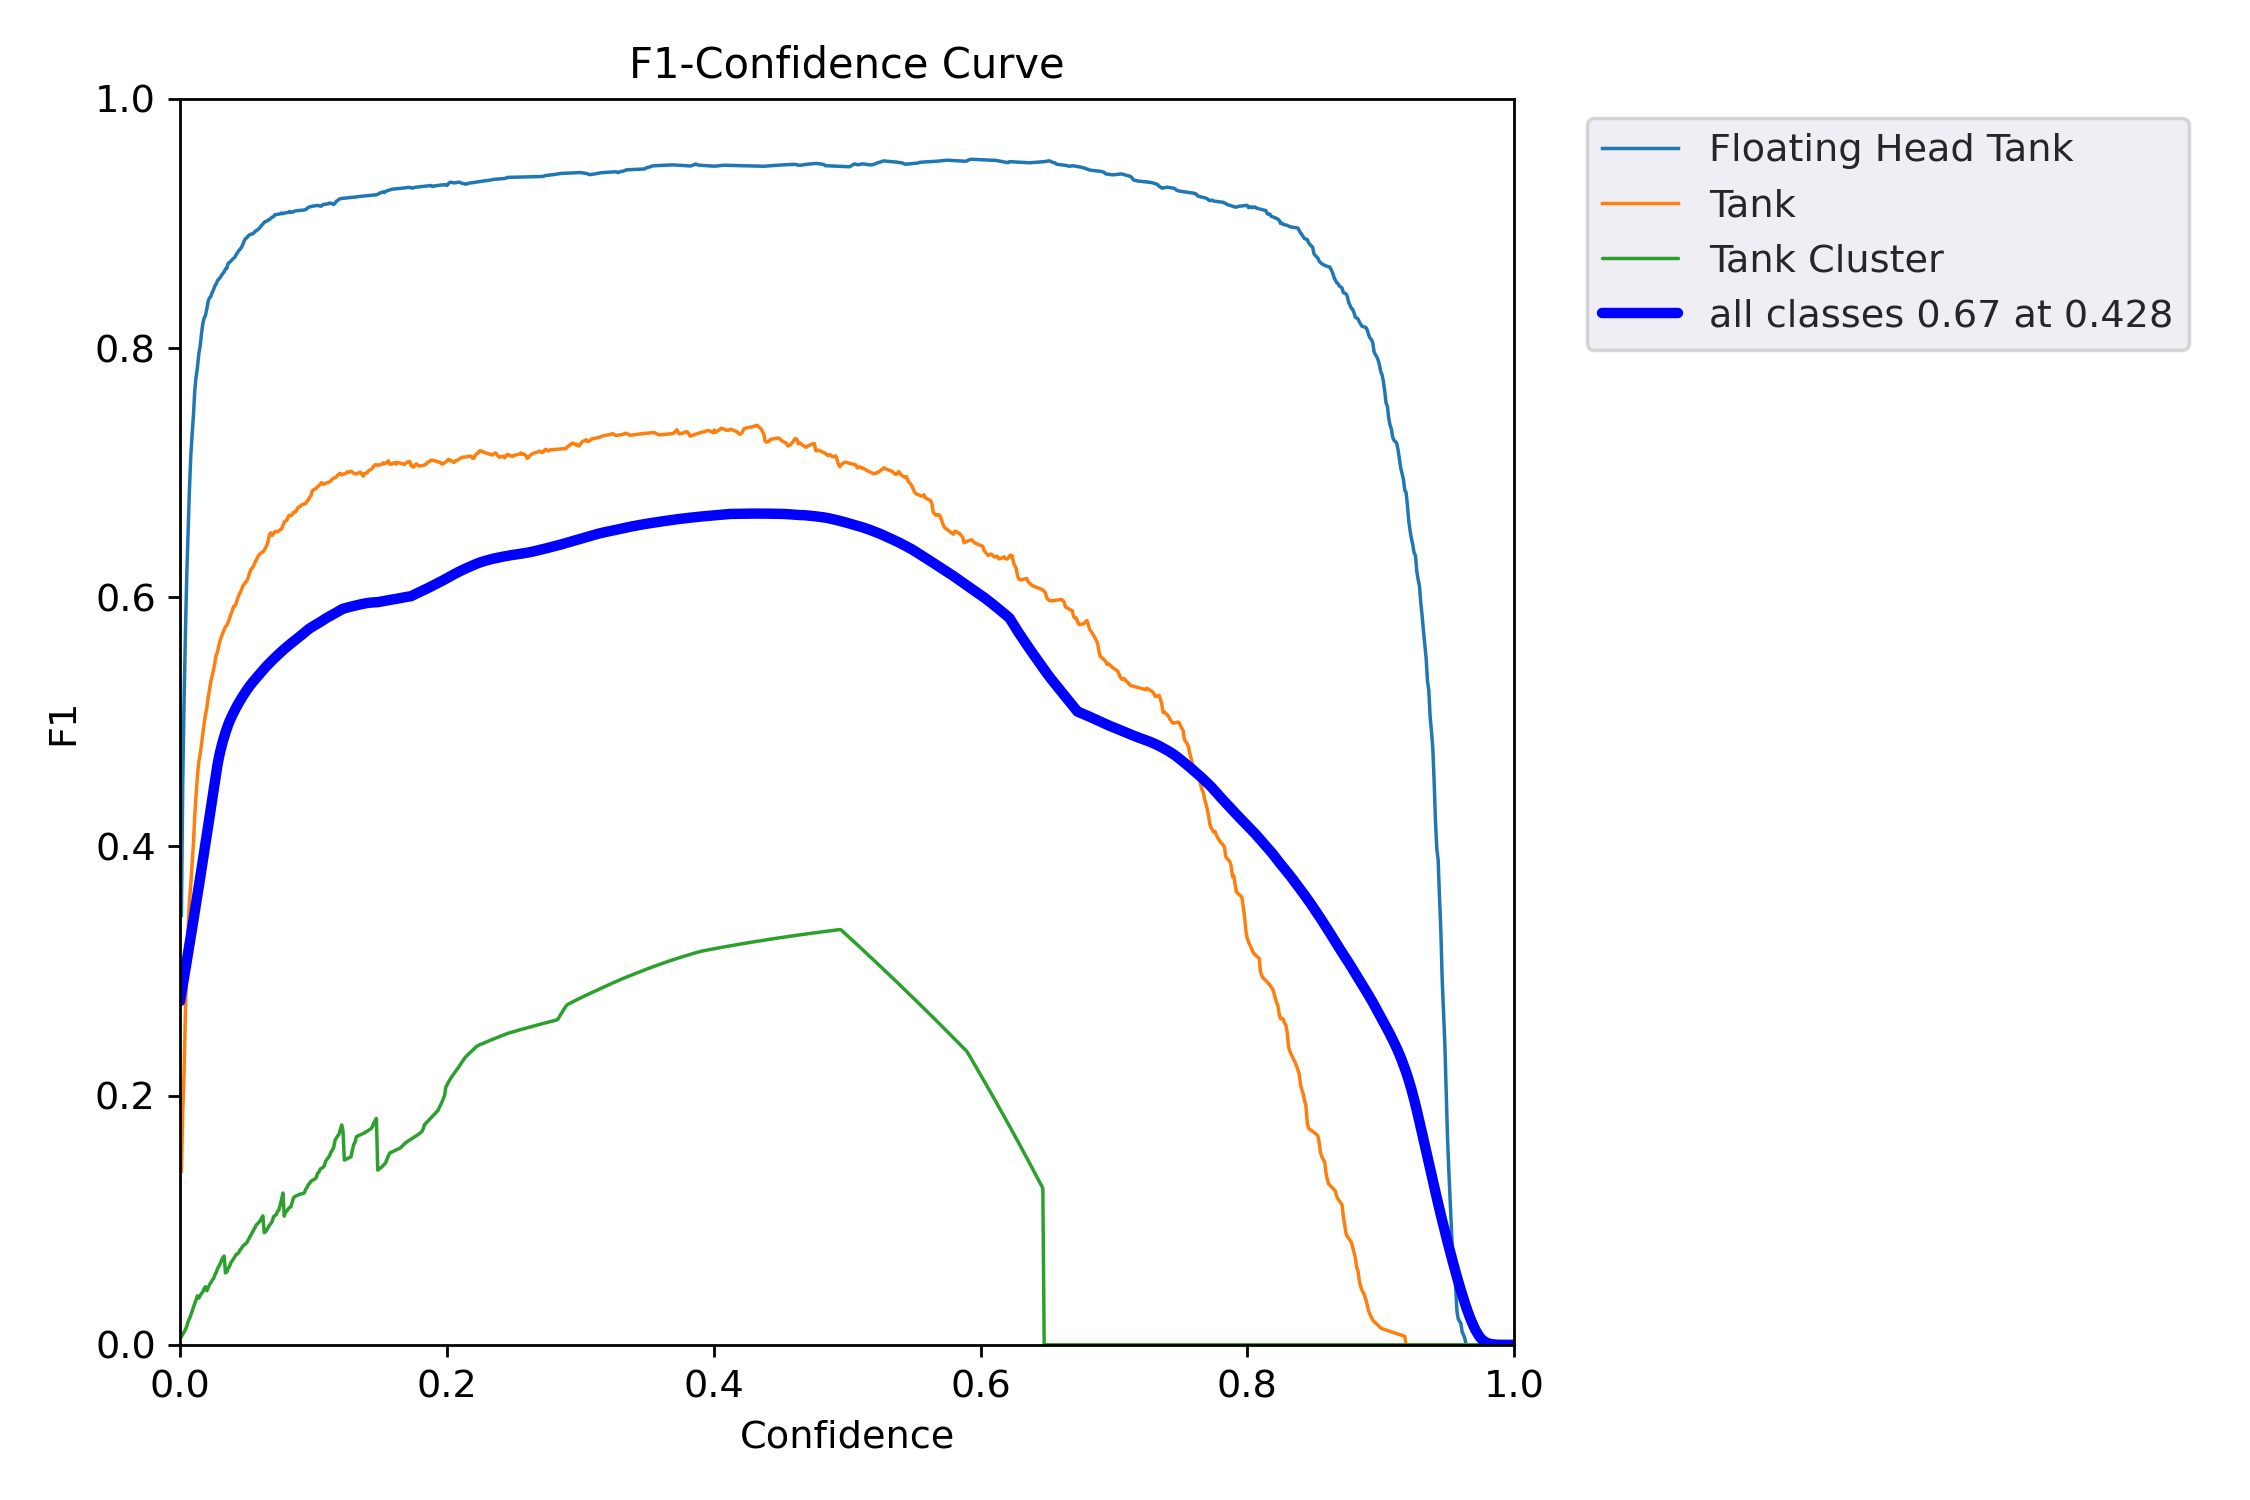

In [6]:
from prettytable import PrettyTable

myTable = PrettyTable(["Model", "MAP Validation Dataset", "MAP Test Dataset"])
  
# Add rows
myTable.add_row(["Yolo V3 with augmentation", "0.958", "0.944"])
myTable.add_row(["Yolo V4 with augmentation", "0.945", "0.918"])
myTable.add_row(["Yolo V5 without augmentation", "0.941", "0.932"])
myTable.add_row(["Yolo V5 with augmentation", "0.989", "0.971"])

print(myTable)

+------------------------------+------------------------+------------------+
|            Model             | MAP Validation Dataset | MAP Test Dataset |
+------------------------------+------------------------+------------------+
|  Yolo V3 with augmentation   |         0.958          |      0.944       |
|  Yolo V4 with augmentation   |         0.945          |      0.918       |
| Yolo V5 without augmentation |         0.941          |      0.932       |
|  Yolo V5 with augmentation   |         0.989          |      0.971       |
+------------------------------+------------------------+------------------+


# Observation

We got good results with Yolov3 but yolo v5 exceeds other models.

Our task is to detect Floating head tank, for which we are getting good Precision score. The input data contains Floating Head Tank, Tank & Tank Clusters. Since the task is to detect Floating head tank, input data doesn't contain many images for Tank and Tank Clusters.

# Prediction

In [ ]:
!python detect.py --weights runs/train/exp2/weights/best.pt --img 512 --conf 0.25 --source ./runs/56_3_0.jpg

Original image

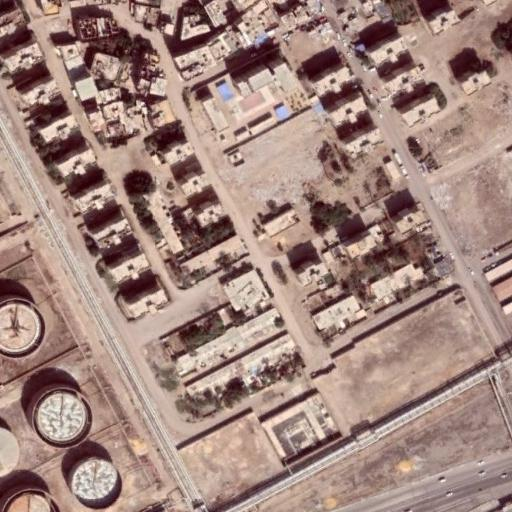

Predicted image

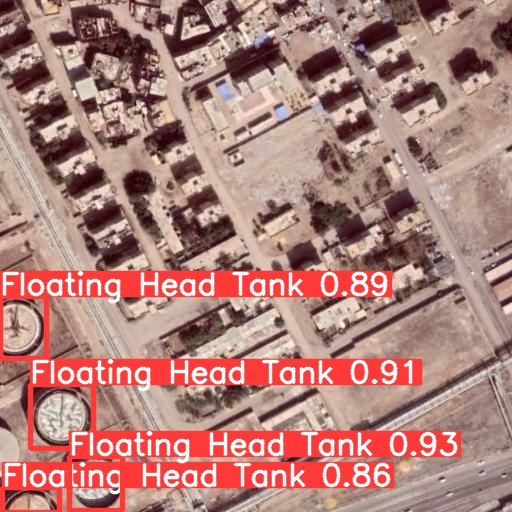